In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner

In [2]:
# Directorios de datos
directorio_entrenamiento = 'C:/Users/krisz/Desktop/LungsXray-FP-main/LungsXray-FP-main/data/Conjuntos_PNEUMONIA/entrenamiento'
directorio_validacion = 'C:/Users/krisz/Desktop/LungsXray-FP-main/LungsXray-FP-main/data/Conjuntos_PNEUMONIA/validacion'
directorio_testeo = 'C:/Users/krisz/Desktop/LungsXray-FP-main/LungsXray-FP-main/data/Conjuntos_PNEUMONIA/testeo'

In [3]:
# Configurar parámetros
batch_size = 32
img_height = 150
img_width = 150

# Preprocesamiento de datos y aumento de datos para entrenamiento
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=15,  # Nueva técnica: rotación
    width_shift_range=0.1,  # Nueva técnica: desplazamiento horizontal
    height_shift_range=0.1,  # Nueva técnica: desplazamiento vertical
)

# Preprocesamiento de datos para validación y prueba (sin aumento)
val_test_data_gen = ImageDataGenerator(rescale=1./255)

# Generadores de datos para entrenamiento, validación y prueba
train_generator = train_data_gen.flow_from_directory(
    directorio_entrenamiento,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Usamos 'binary' porque ya tenemos las etiquetas en los nombres de los archivos
    shuffle=True
)

val_generator = val_test_data_gen.flow_from_directory(
    directorio_validacion,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # No es necesario barajar el conjunto de validación
)

test_generator = val_test_data_gen.flow_from_directory(
    directorio_testeo,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # No es necesario barajar el conjunto de prueba
)

Found 3356 images belonging to 2 classes.
Found 719 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


In [4]:
def build_model(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
            activation='relu',
            input_shape=(img_height, img_width, 3),
            kernel_regularizer=l2(0.01)
        ),
        MaxPooling2D((2, 2)),    
        Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=32),
            kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ),
        MaxPooling2D((2, 2)),    
        Conv2D(
            filters=hp.Int('conv_3_filter', min_value=64, max_value=128, step=32),
            kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ),
        MaxPooling2D((2, 2)),    
        Flatten(),
        Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ),
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    

    # Compilar el modelo con la tasa de aprendizaje
    model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [5]:
# Configuración del sintonizador
tuner = keras_tuner.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    hyperband_iterations=2,  
    directory='Pneumonia_Hyperband',
    project_name='Enfermedades'
)

In [6]:
# Implementar EarlyStopping para detener el entrenamiento si no mejora la métrica de validación
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [7]:
for trial in range(30):
    tuner.search(train_generator, validation_data=val_generator,callbacks=[early_stopping])
    tf.keras.backend.clear_session()

Trial 20 Complete [00h 04m 28s]
val_accuracy: 0.9012517333030701

Best val_accuracy So Far: 0.924895703792572
Total elapsed time: 00h 59m 38s


In [8]:
# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

In [9]:
# Obtener los mejores hiperparámetros
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'conv_1_filter': 64, 'conv_1_kernel': 5, 'conv_2_filter': 32, 'conv_2_kernel': 3, 'conv_3_filter': 64, 'conv_3_kernel': 5, 'dense_1_units': 64, 'dropout': 0.1, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [10]:
# Implementar EarlyStopping para detener el entrenamiento si no mejora la métrica de validación
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Implementar ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
model_checkpoint = ModelCheckpoint('modelo_Pneumonia_hiperparametros_hyperband.h5', save_best_only=True)

In [11]:
# Entrenar el mejor modelo con los datos del generador, agregar regularización y ajustar pesos de clase
history = best_model.fit(
    train_generator,
    epochs=50,  # Ajusta según sea necesario
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=None  # Puedes ajustar esto si encuentras desequilibrios en la distribución de clases
)

Epoch 1/50
105/105 [==============================] - 48s 443ms/step - loss: 0.4259 - accuracy: 0.8576 - val_loss: 0.3477 - val_accuracy: 0.8999
Epoch 2/50


d:\Users\krisz\miniconda3\envs\clase\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 48s 458ms/step - loss: 0.4008 - accuracy: 0.8650 - val_loss: 0.3005 - val_accuracy: 0.9249
Epoch 3/50
105/105 [==============================] - 48s 452ms/step - loss: 0.3940 - accuracy: 0.8740 - val_loss: 0.2977 - val_accuracy: 0.9138
Epoch 4/50
105/105 [==============================] - 49s 461ms/step - loss: 0.3899 - accuracy: 0.8683 - val_loss: 0.3295 - val_accuracy: 0.9040
Epoch 5/50
105/105 [==============================] - 47s 450ms/step - loss: 0.3649 - accuracy: 0.8823 - val_loss: 0.3443 - val_accuracy: 0.8985
Epoch 6/50
105/105 [==============================] - 48s 455ms/step - loss: 0.3775 - accuracy: 0.8778 - val_loss: 0.3098 - val_accuracy: 0.9235
Epoch 7/50
105/105 [==============================] - 47s 442ms/step - loss: 0.3891 - accuracy: 0.8763 - val_loss: 0.2706 - val_accuracy: 0.9263
Epoch 8/50
105/105 [==============================] - 47s 444ms/step - loss: 0.3753 - accuracy: 0.8838 - val_loss: 0.2993 - val_accuracy: 0.9

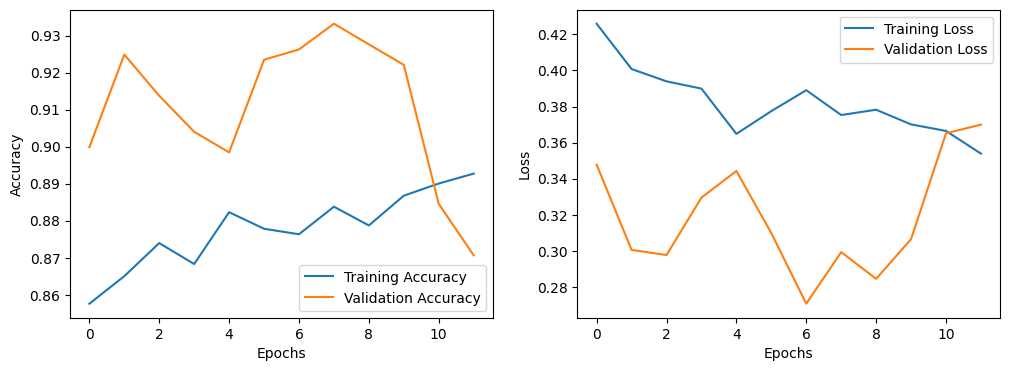

23/23 - 14s - loss: 0.2356 - accuracy: 0.9500 - 14s/epoch - 620ms/step

Exactitud en el conjunto de prueba: 0.949999988079071
23/23 [==============================] - 3s 109ms/step


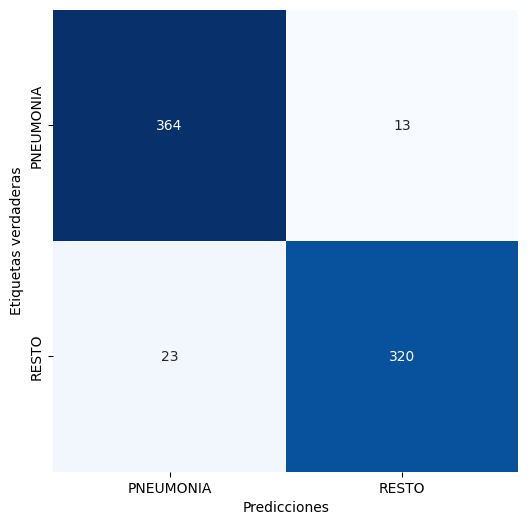

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       377
           1       0.96      0.93      0.95       343

    accuracy                           0.95       720
   macro avg       0.95      0.95      0.95       720
weighted avg       0.95      0.95      0.95       720



In [12]:
# Visualizar el rendimiento del modelo
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = best_model.evaluate(test_generator, verbose=2)
print('\nExactitud en el conjunto de prueba:', test_acc)

# Predicciones en el conjunto de prueba
y_pred = best_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)

# Matriz de confusión
conf_mat = confusion_matrix(test_generator.classes, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=train_generator.class_indices,
            yticklabels=train_generator.class_indices)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

# Informe de clasificación
print(classification_report(test_generator.classes, y_pred_classes))

In [13]:
modelo = load_model('C:/Users/krisz/Desktop/LungsXray-FP-main/LungsXray-FP-main/src/modelo_Pneumonia_hiperparametros_hyperband.h5')

1/1 [==============================] - 0s 18ms/step


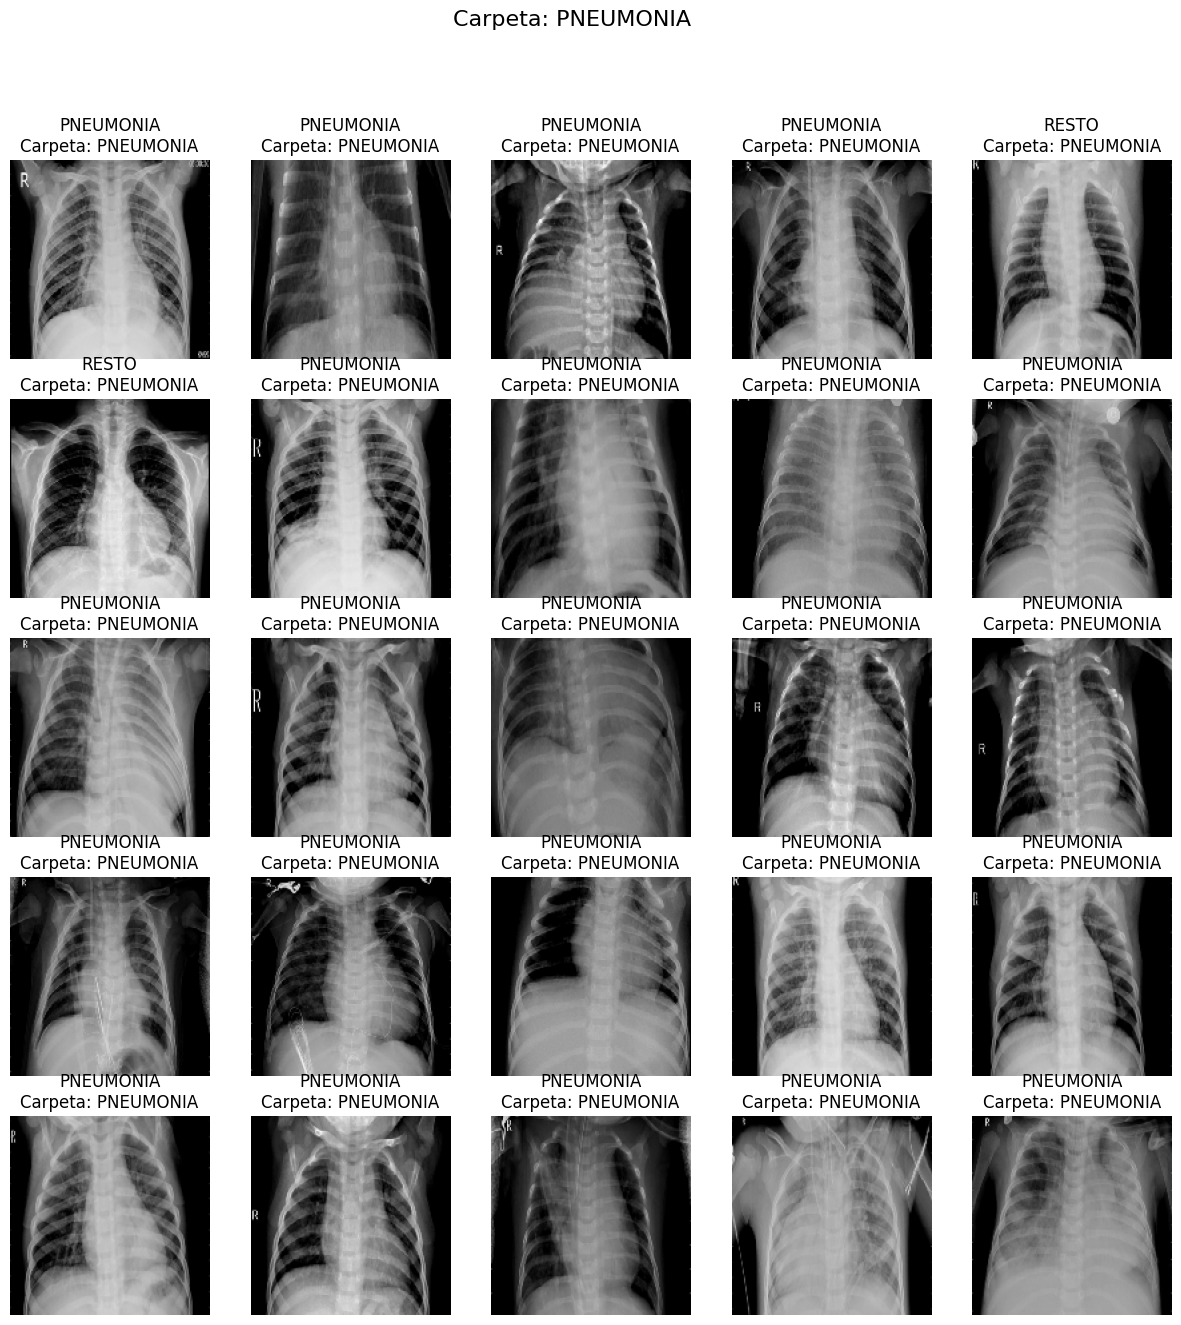

1/1 [==============================] - 0s 47ms/step


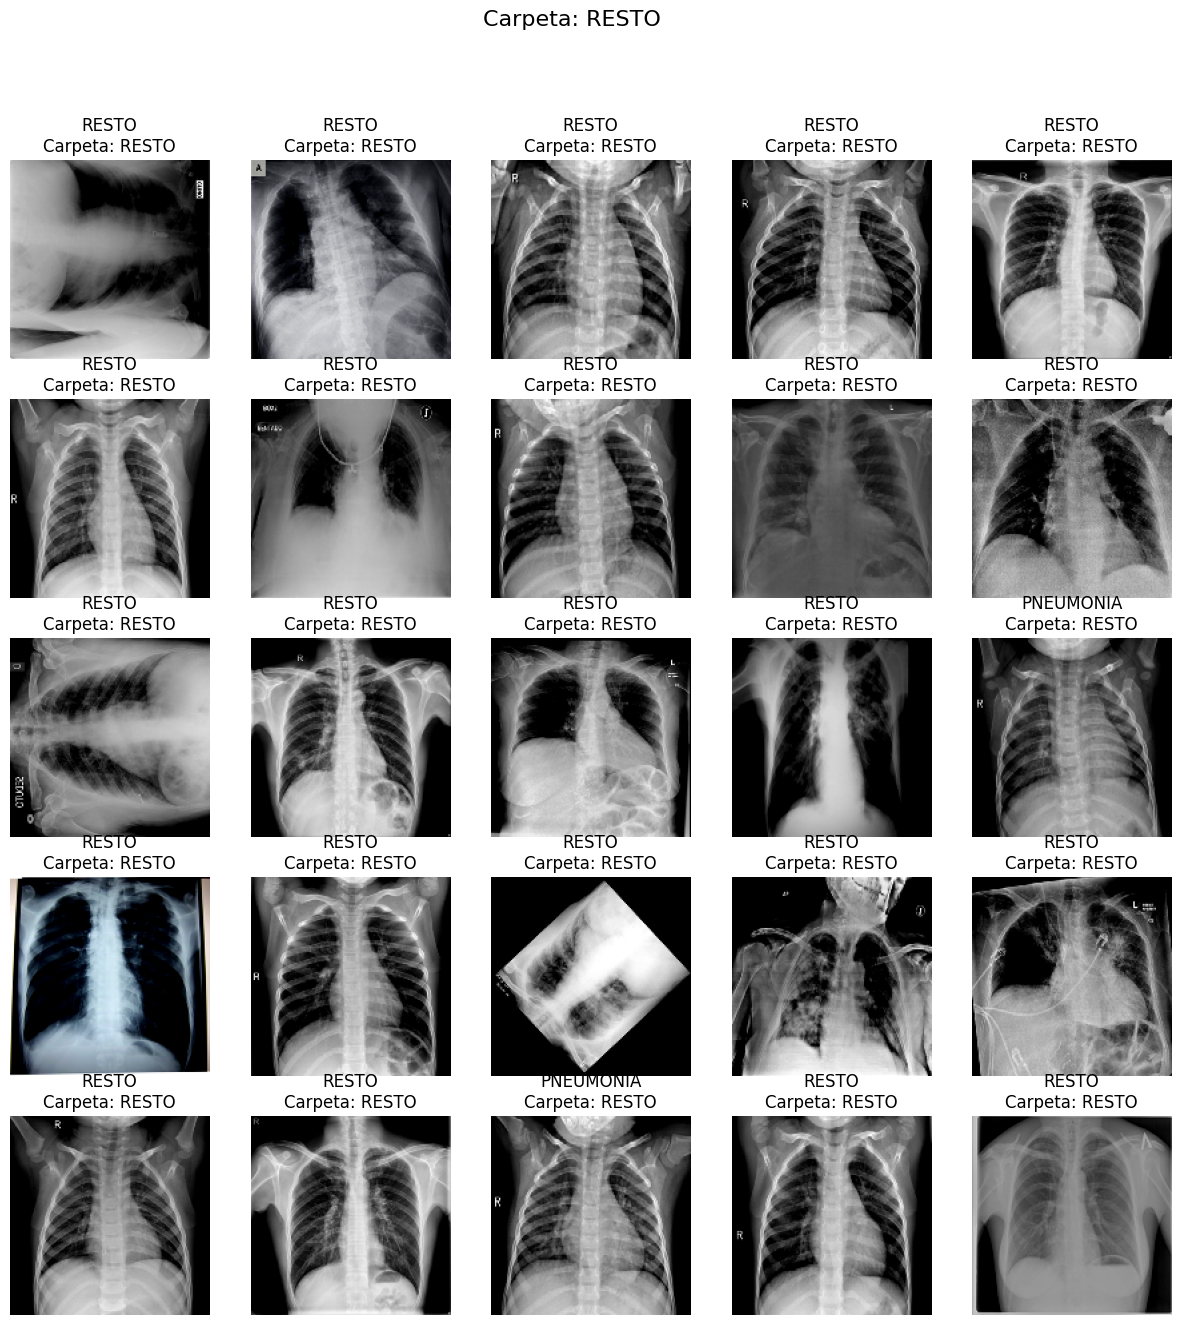

In [15]:
# Función para mostrar imágenes con predicciones en una cuadrícula
def mostrar_imagenes_predicciones(modelo, directorio, num_imagenes_por_clase=25, columnas=5):
    clases = os.listdir(directorio)
    
    for clase in clases:
        ruta_clase = os.path.join(directorio, clase)
        imagenes = random.sample(os.listdir(ruta_clase), num_imagenes_por_clase)
        
        # Crear una cuadrícula de subgráficos
        fig, axs = plt.subplots(nrows=num_imagenes_por_clase//columnas, ncols=columnas, figsize=(15, 15))
        fig.suptitle(f'Carpeta: {clase}', fontsize=16)

        for i, imagen_nombre in enumerate(imagenes):
            imagen_path = os.path.join(ruta_clase, imagen_nombre)
            img = image.load_img(imagen_path, target_size=(img_height, img_width))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Normalizar

            prediccion = modelo.predict(img_array)
            clase_predicha = 'PNEUMONIA' if prediccion < 0.5 else 'RESTO'

            # Mostrar cada imagen en un subgráfico
            row = i // columnas
            col = i % columnas
            axs[row, col].imshow(img)
            axs[row, col].set_title(f'{clase_predicha}\nCarpeta: {clase}')
            axs[row, col].axis('off')

        plt.show()

# Ruta al directorio con subcarpetas de imágenes de prueba
ruta_directorio_prueba = 'C:/Users/krisz/Desktop/LungsXray-FP-main/LungsXray-FP-main/data/Conjuntos_Pneumonia/testeo'

# Llamar a la función para mostrar imágenes y predicciones en una cuadrícula
mostrar_imagenes_predicciones(modelo, ruta_directorio_prueba)